In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil

import nibabel as nib

import nilearn
from nilearn.masking import apply_mask
from nilearn.plotting import plot_img, plot_epi, plot_roi, plot_stat_map
from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.input_data import NiftiMasker

import nitime
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv

import scipy

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
%matplotlib inline

In [4]:
nib.__version__

'2.4.1'

In [5]:
nilearn.__version__

'0.5.2'

In [6]:
nitime.__version__

'0.8.1'

In [7]:
scipy.__version__

'1.3.0'

### Test the confounds file exists

In [7]:
confounds_file = "/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-02_desc-confounds_regressors.tsv"

In [8]:
confounds_df = pd.read_csv(confounds_file, sep=str('\t'), na_values="n/a")

FileNotFoundError: [Errno 2] File b'/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-02_desc-confounds_regressors.tsv' does not exist: b'/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-02_desc-confounds_regressors.tsv'

In [9]:
confounds_df.head()

,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,aroma_motion_05,aroma_motion_11,aroma_motion_17,aroma_motion_18,aroma_motion_19,aroma_motion_20
0,470.413801,NaN,221289.144110,NaN,502.865752,NaN,NaN,252873.964530,623.719160,NaN,...,0.002864,NaN,0.000008,NaN,-2.345714,-0.939522,0.632634,0.660056,2.721804,1.864549
1,465.227346,-5.186455,216436.483031,26.899320,502.404673,-0.461079,0.212594,252410.455711,621.257942,-2.461218,...,0.002420,-0.000444,0.000006,1.968608e-07,-2.028463,-2.359410,0.182195,0.311244,0.890193,-0.638706
2,461.218749,-4.008596,212722.734655,16.068844,502.200712,-0.203962,0.041600,252205.554869,620.422218,-0.835724,...,0.002321,-0.000099,0.000005,9.822792e-09,-2.659588,-1.457759,-0.316505,2.153198,-0.416179,0.497415
3,463.294177,2.075428,214641.494791,4.307402,501.560595,-0.640117,0.409749,251563.030456,620.192733,-0.229484,...,0.002544,0.000223,0.000006,4.976022e-08,-2.607786,-0.602677,-0.225781,-0.551552,-0.336480,0.425595
4,460.843536,-2.450641,212376.764878,6.005642,502.658903,1.098308,1.206281,252665.973151,619.951292,-0.241442,...,0.002316,-0.000228,0.000005,5.197944e-08,-2.538504,-0.356082,0.301863,1.284738,-0.150039,-1.943029


In [10]:
poss_confounds = list(confounds_df.columns)
poss_confounds[:5]

['csf',
 'csf_derivative1',
 'csf_power2',
 'csf_derivative1_power2',
 'white_matter']

### Define paths etc

In [8]:
raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/")
out_dir = os.path.abspath('/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/')
mypreproc_bids_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/AV_20111117/")
fmriprep_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/")
sub = "AV"
ses = "20111117"

#### Move files

In [8]:
events_glob = f"{mypreproc_bids_dir}/sub-{sub}/ses-{ses}/func/*events.tsv"
task_json_glob = f"{mypreproc_bids_dir}/sub-{sub}/ses-{ses}/func/*task*json"
print(glob.glob(task_json_glob), sep="\n")

['/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-01_bold.json', '/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_bold.json', '/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-07_bold.json', '/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-06_bold.json', '/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-03_bold.json', '/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-05_bold.json', '/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-08_bold.json', '/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-02_bold.json', '/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-2011111

In [47]:
for e in glob.glob(events_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    shutil.copyfile(e, new_file_name)

/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-01_events.tsv
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-01_events.tsv
/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_events.tsv
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_events.tsv
/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-04_events.tsv
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-04_events.tsv
/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-03_events.tsv
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-03_events.tsv
/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV

In [48]:

for e in glob.glob(task_json_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    shutil.copyfile(e, new_file_name)

/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-01_bold.json
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-01_bold.json
/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_bold.json
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_bold.json
/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-07_bold.json
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-07_bold.json
/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-06_bold.json
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-06_bold.json
/Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/func/sub-AV_ses-201

### Fix the event files

For this subject, I consulted the scan log to line up the scans to runs and moved the files around manually

In [ ]:
blocks_in_order = ['L', 'R']
for thisrun in [1, 2, 3, 4]:
    events_fn = f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-{thisrun:02d}_events.tsv"
    events_file_contents = f"onset\tduration\ttrial_type\n"
    time_between_onsets = 13.5
    for i in range(22):
        events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
    with open(events_fn, 'w') as f:
        f.write(events_file_contents)
    #print(events_fn, '\n', events_file_contents)

## GLM invocation from a cell

### Only run one of the next two cells! (Picks which task and runs to analyze)

#### Hemifield

In [9]:
task = "hemi"
runs = [1, 2]
space="T1w"

#### MP

In [14]:
task = "mp"
runs = [1, 2, 3, 4, 5, 6, 7, 8]
space="T1w"

### Use functions from utils to get files that would be passed to workflow

In [12]:
from bids import BIDSLayout

In [ ]:
BIDSLayout??

In [16]:
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)

In [ ]:
raw_layout.files

In [27]:
preproc_layout = BIDSLayout(fmriprep_dir, validate=False)

In [32]:
masks = sorted([f for f in preproc_layout.get(subject=sub, suffix='mask',
            session=ses, run=[], task=task, extension=['nii.gz'], return_type='file')])

In [33]:
masks * 2

[]

In [14]:
preproc_layout.files

{'/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/.DS_Store': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/.DS_Store'>,
 '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/.DS_Store': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/.DS_Store'>,
 '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/.DS_Store': <BIDSFile filename='/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/.DS_Store'>,
 '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-05_desc-preproc_bold.nii.gz': <BIDSImageFile filename='/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-05_desc-preproc_bold.nii.gz'>,
 '/Users/smerdis/data/LGN/BIDS/AV_2

In [17]:
subjects = preproc_layout.get_subjects()
assert sub in subjects and sub in raw_layout.get_subjects(), "Subject not found!"

sessions = preproc_layout.get_sessions()
assert ses in sessions, "Session not found!"

tasks = preproc_layout.get_tasks()
assert task in tasks, "Task not found!"

In [ ]:
preproc_layout.get??

In [ ]:
bolds = [preproc_layout.get(subject=sub, suffix='preproc',
                              session=ses, task=task, run=runs, extensions=['nii.gz'],
                                               return_type='file')]
print(f"BOLDS: {len(bolds)}\n{bolds}")

In [ ]:
raw_bolds = raw_layout.get(subject=sub, suffix="bold",
                           task=task, session=ses, run=runs, extensions=['nii.gz'])

In [ ]:
raw_bolds

In [ ]:
raw_layout.get_tr(raw_bolds[0].filename)

In [ ]:
TRs = [raw_layout.get_tr(f.filename) for f in raw_bolds]

In [ ]:
TRs

### Use the actual utils.py function

In [10]:
bolds, masks, eventfiles, TR, confounds = utils.get_files_fmriprep14(sub, ses, task,
    raw_data_dir, fmriprep_dir, run=runs)

Space is None
BOLDS: 2
['/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-01_desc-preproc_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_desc-preproc_bold.nii.gz']
Masks: 2
['/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_desc-brain_mask.nii.gz', '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_desc-brain_mask.nii.gz']
Eventfiles: 2
['/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-01_events.tsv', '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_events.tsv']
[2.25, 2.25] 2
Confounds: 0
[]


In [11]:
# runs is a list containing the fmriprep run numbers we want to analyze
# so run is the fmriprep run number, and run_idx is its position in runs
run = 2
if run not in runs:
    print('Error, that run is not present for this task!')
else:
    run_idx = runs.index(run)
    bold_file = bolds[run_idx]
    mask_file = masks[run_idx]
    print(run, bold_file, mask_file, sep="\n")

2
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_desc-preproc_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_desc-brain_mask.nii.gz


### Just load the files directly

In [12]:
anat_file = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}", 'anat', f"sub-{sub}_desc-preproc_T1w.nii.gz")
#func = os.path.join(fmriprep_dir, bolds[0])
#mROI = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-01_lLGN_roi_manual.nii.gz")

In [13]:
# nipype_dir = f"{out_dir}/nipype_AV_20111117_mp_2019-11-26_20-26-54" #mp (update each time glm is run)
# nipype_dir = f"{out_dir}/nipype_AV_20111117_hemi_2019-11-26_21-06-50" #hemi (update each time glm is run)
nipype_dir = f"{out_dir}/nipype_AV_20111117_{task}_rdpreproc_noconfounds"
wf_dir = f"{nipype_dir}/{task}/modelfit"
datasink_dir = os.path.join(wf_dir, 'datasink')
print(datasink_dir)

/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink


In [14]:
hemi_command = f"python glm_hemi_AV20111117_rdpreproc.py {raw_data_dir} \
{out_dir} {sub} {ses} hemi None {nipype_dir} \"[1, 2]\""
mp_command = f"python glm_mp_AV20111117.py {raw_data_dir} \
{out_dir} {sub} {ses} mp {space} {nipype_dir} \"{runs}\""
print(hemi_command)
print(mp_command)

python glm_hemi_AV20111117_rdpreproc.py /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives AV 20111117 hemi None /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds "[1, 2]"
python glm_mp_AV20111117.py /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/sub-AV /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives AV 20111117 mp T1w /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds "[1, 2]"


In [15]:
!ls "{datasink_dir}"

_0x6acfc816496280017a0e96ef63333b25.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir


In [16]:
!ls "{datasink_dir}/results_dir"

_modelestimate0 _modelestimate1


### Filenames of other maps etc we want to overlay on our images

In [59]:
coh_fn = f"{out_dir}/nitime/sub-{sub}_ses-{ses}_task-hemi_run-02_desc-coherence_map.nii"
print(coh_fn)
!ls {coh_fn}

/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nitime/sub-AV_ses-20111117_task-hemi_run-02_desc-coherence_map.nii
/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nitime/sub-AV_ses-20111117_task-hemi_run-02_desc-coherence_map.nii


In [26]:
# from fsleyes 0.32
def isBIDSFile(filename, strict=True):
    """Returns ``True`` if ``filename`` looks like a BIDS image or JSON file.

    :arg filename: Name of file to check
    :arg strict:   If ``True`` (the default), the file must be within a BIDS
                   dataset directory, as defined by :func:`inBIDSDir`.
    """

    name    = os.path.basename(filename)
    pattern = r'([a-z0-9]+-[a-z0-9]+_)*([a-z0-9])+\.(nii|nii\.gz|json)'
    flags   = re.ASCII | re.IGNORECASE
    match   = re.fullmatch(pattern, name, flags) is not None
    
    print(name, match)

    return ((not strict) or inBIDSDir(filename)) and match

In [27]:
isBIDSFile(coh_fn)

sub-AV_ses-20111117_task-hemi_desc-coherence_map.nii True


NameError: name 'inBIDSDir' is not defined

### View the contrast beta maps overlaid on the functional and anatomical images

In [52]:
contrasts = utils.get_contrasts(task)

In [53]:
contrasts

[['L>Baseline', 'T', ['L', 'R'], [1, 0]],
 ['R>Baseline', 'T', ['L', 'R'], [0, 1]],
 ['R-L', 'T', ['L', 'R'], [-1, 1]],
 ['Task>Baseline', 'T', ['L', 'R'], [0.5, 0.5]]]

In [54]:
contrast_idx = 2 # position in the list of contrasts (zero-indexed)
contrast = contrast_idx + 1 # suffix number of the level 1 COPE file for that contrast
l1copes, l2copes = utils.get_model_outputs(datasink_dir, [contrast])

In [55]:
l1copes

['/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/results_dir/_modelestimate0/results/cope3.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/results_dir/_modelestimate1/results/cope3.nii.gz']

In [56]:
l2copes

['/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz']

In [57]:
utils.view_results(datasink_dir, [contrast], anat_file, bold_file)

'fsleyes /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/anat/sub-AV_desc-preproc_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-01_desc-preproc_bold.nii.gz  /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/results_dir/_modelestimate0/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/results_dir/_modelestimate1/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz'

In [64]:
print(f"{utils.view_results(datasink_dir, [3], anat_file, bold_file)} {coh_fn}") # R-L

fsleyes /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/anat/sub-AV_desc-preproc_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-01_desc-preproc_bold.nii.gz  /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/results_dir/_modelestimate0/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/results_dir/_modelestimate1/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nipype_AV_20111117_hemi_rdpreproc_noconfounds/hemi/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nitime/sub-AV_ses-20111117_task-hemi_run-02_desc-coherence_map.nii


### View these files using nilearn tools

#### First establish some coordinates to view at

In [99]:
# cut in x-direction
sagittal = 43
# cut in y-direction
coronal = 27
# cut in z-direction
axial = -2

# coordinates displaying should be prepared as a list
cut_coords = [sagittal, coronal, axial]

#### Now begin plotting

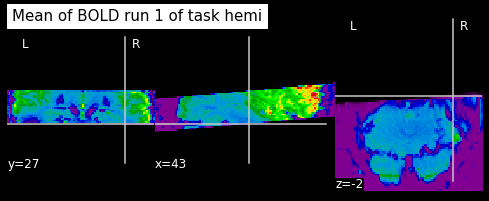

In [100]:
mean_bold = mean_img(bold_file)
plot_epi(mean_bold, title=f"Mean of BOLD run {run} of task {task}", cut_coords=cut_coords)

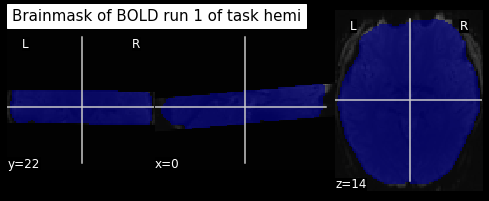

In [101]:
plot_roi(mask_file, mean_bold, title=f"Brainmask of BOLD run {run} of task {task}")

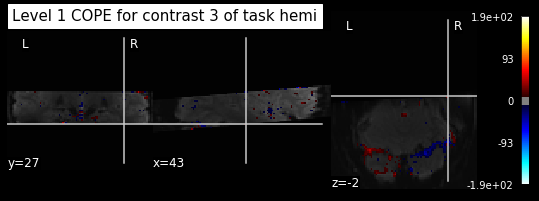

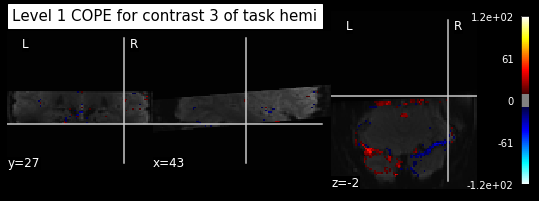

In [102]:
for l1cope in l1copes:
    plot_stat_map(l1cope, mean_bold,
        title=f"Level 1 COPE for contrast {contrast} of task {task}",
        threshold=10, cut_coords=cut_coords, colorbar=True)

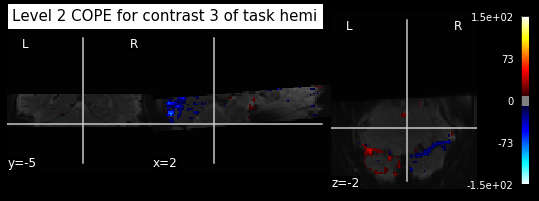

In [103]:
plot_stat_map(l2copes[0], mean_bold,
    title=f"Level 2 COPE for contrast {contrast} of task {task}",
    threshold=10, cut_coords=[2, -5, -2])

### LGN region drawing/manipulation!

In [31]:
manual_roi = f"{out_dir}/sub-NB_R-LGN_mask_manual.nii.gz"

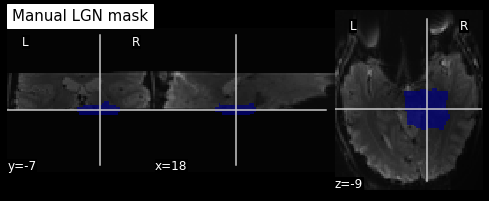

In [32]:
plot_roi(manual_roi, mean_bold, title=f"Manual LGN mask")

In [33]:
r_lgn_mask_manual = load_img(manual_roi).get_data().astype(bool)
r_lgn_mask_manual.shape

(84, 102, 82)

## Coherence analysis to identify LGN voxels responding at flicker frequency

### raw nibabel

In [ ]:
img = nib.load(bold_file)

In [ ]:
print(img.header)

In [ ]:
img_data = img.get_fdata()

In [ ]:
plt.imshow(img_data[26, :, :, 44].T, cmap="gray", origin="lower")

In [ ]:
nvox = img.shape[0] * img.shape[1] * img.shape[2]

In [ ]:
n_timepoints = img.shape[-1]

In [ ]:
print(nvox, n_timepoints)

In [ ]:
img_flat = np.reshape(img_data, (nvox, -1))

In [ ]:
img_flat[:10, 0]

In [ ]:
#TR = 2.25 # seconds
freq = 4 # Hz
total_len = img.shape[-1]*TR # seconds
fig, ax = plt.subplots(1)
t = np.arange(0.0, total_len, 0.05)
sinusoid = np.sin(freq*2*np.pi*t)
print(sinusoid.shape)

ax.set_xlim(0, 8)
ax.plot(t, sinusoid)

In [ ]:
2.25*139

### Begin coherence analysis in nitime

In [12]:
#run = 2
TR = 2.25
#bold_file = f"/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-{run:02d}_desc-preproc_bold.nii.gz"

0.037037037037037035
[  0.     2.25   4.5    6.75   9.    11.25  13.5   15.75  18.    20.25
  22.5   24.75  27.    29.25  31.5   33.75  36.    38.25  40.5   42.75
  45.    47.25  49.5   51.75  54.    56.25  58.5   60.75  63.    65.25
  67.5   69.75  72.    74.25  76.5   78.75  81.    83.25  85.5   87.75
  90.    92.25  94.5   96.75  99.   101.25 103.5  105.75 108.   110.25
 112.5  114.75 117.   119.25 121.5  123.75 126.   128.25 130.5  132.75
 135.   137.25 139.5  141.75 144.   146.25 148.5  150.75 153.   155.25
 157.5  159.75 162.   164.25 166.5  168.75 171.   173.25 175.5  177.75
 180.   182.25 184.5  186.75 189.   191.25 193.5  195.75 198.   200.25
 202.5  204.75 207.   209.25 211.5  213.75 216.   218.25 220.5  222.75
 225.   227.25 229.5  231.75 234.   236.25 238.5  240.75 243.   245.25
 247.5  249.75 252.   254.25 256.5  258.75 261.   263.25 265.5  267.75
 270.   272.25 274.5  276.75 279.   281.25 283.5  285.75 288.   290.25
 292.5  294.75 297.   299.25 301.5  303.75 306.   308.25

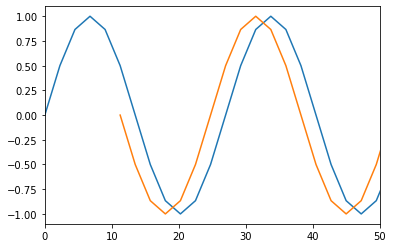

In [13]:
cycle_duration = 27 # (should be 27s)
hemi_freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*TR # seconds

trs_exc_beg = 6
trs_exc_end = 1

f_lb = 0.02
f_ub = 0.15

print(hemi_freq)

t = np.arange(0.0, total_len, TR)
t_trim = np.arange((trs_exc_beg-1)*TR, (total_len - trs_exc_beg - trs_exc_end)+1, TR)
hemifield_alternation_sinusoid = np.sin(hemi_freq*2*np.pi*t)
hemi_alt_trim = hemifield_alternation_sinusoid[trs_exc_beg:(-1*trs_exc_end)]
print(t, hemifield_alternation_sinusoid.shape)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t_trim, hemi_alt_trim)

In [14]:
hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=TR)
hemi_ts_trim = ts.TimeSeries(data=hemi_alt_trim,
                         sampling_interval=TR)

In [15]:
hemi_ts.shape, hemi_ts_trim.shape

((139,), (132,))

#### Using NiftiMasker

In [16]:
#masker = NiftiMasker(mask_img=mask_file, standardize=False, mask_strategy="epi")
masker = NiftiMasker(mask_img=mask_file, standardize=False, mask_strategy="epi", detrend='mean',
                     low_pass=f_ub, high_pass=f_lb, t_r=TR, verbose=3)
masked_bold_nm = masker.fit_transform(bold_file)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_desc-preproc_bold.nii.gz')
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [17]:
masked_bold_nm.shape

(139, 117635)

In [18]:
trim_bold_nm = masked_bold_nm[trs_exc_beg:(-1*trs_exc_end),:]
trim_bold_nm.shape

(132, 117635)

In [19]:
trim_bold_nm[:, :10]

array([[-12.291897  ,  -7.252282  ,  -2.408518  , ...,  -3.8619752 ,
          0.9061406 ,  -2.753961  ],
       [-20.27465   , -17.275951  ,  -8.43119   , ...,   1.8394167 ,
         -7.4014916 , -13.734376  ],
       [ -2.3305423 ,  -1.9527972 ,  -9.262912  , ...,   6.9776907 ,
        -10.410575  ,  -7.4877114 ],
       ...,
       [  0.07672162,   7.588031  ,  -0.076931  , ...,   5.445324  ,
        -10.105915  ,   1.7094467 ],
       [ -5.5874233 ,   2.4686027 ,  -0.75264513, ...,   6.1878815 ,
        -18.929157  ,   3.7713819 ],
       [ -7.097235  ,  -3.020071  ,  -3.369966  , ...,   3.6446338 ,
        -19.385977  ,  -2.129652  ]], dtype=float32)

In [20]:
voxel_means = np.mean(trim_bold_nm, axis=0)
voxel_means[32]

-0.136867

In [21]:
voxel_means

array([-0.22154498, -0.08300295, -0.28164604, ..., -0.05251158,
        0.1098647 ,  0.0831864 ], dtype=float32)

In [22]:
demean = trim_bold_nm/voxel_means

### figure out how to mask the whole bold timeseries with an roi

 * write a function to mask an ndarray of bold data wwith a binary ROI mask
   * fsl ApplyMask() through nipype etc?
     * just write it in the notebook at first
     * but eventually this should run on nipype so it can be deployed on the server
 * apply this to each specified run and return the timeseries
 * do the coherence graphs and calculate coherence for all the voxels

In [78]:
import nipype.interfaces.fsl as fsl

In [79]:
print(f"python mask_lgn.py \
/Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB \
/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives \
NB 20190205 hemi T1w \"[1]\"")

python mask_lgn.py /Users/smerdis/data/LGN/BIDS/NB_combined/sub-NB /Users/smerdis/data/LGN/BIDS/NB_combined/derivatives NB 20190205 hemi T1w "[1]"


In [ ]:
masked_bold = f"/Users/smerdis/data/LGN/BIDS/NB_combined/derivatives/nipype_NB_20190205_hemi/\
masking/masker/datasink/epi_masked/_applymask0/\
sub-NB_ses-20190205_task-hemi_acq-sbiso_run-01_bold_space-T1w_preproc_masked.nii.gz"

In [ ]:
print(masked_bold)

### begin coherence stuff

#### dummy stuff to see how coherence works

In [ ]:
timepad = np.pad(hemifield_alternation_sinusoid, (3,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad2 = np.pad(hemifield_alternation_sinusoid, (6,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad3 = np.pad(hemifield_alternation_sinusoid, (8,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]

In [ ]:
fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t, timepad)
ax.plot(t, timepad2)
ax.plot(t, timepad3)

#### analyze the real fmri data

In [23]:
masked_ts_flat = trim_bold_nm.T # want nvox, n_tp so transpose NiftiMasker result
demean_ts_flat = demean.T

[ 11.25  13.5   15.75  18.    20.25  22.5   24.75  27.    29.25  31.5
  33.75  36.    38.25  40.5   42.75  45.    47.25  49.5   51.75  54.
  56.25  58.5   60.75  63.    65.25  67.5   69.75  72.    74.25  76.5
  78.75  81.    83.25  85.5   87.75  90.    92.25  94.5   96.75  99.
 101.25 103.5  105.75 108.   110.25 112.5  114.75 117.   119.25 121.5
 123.75 126.   128.25 130.5  132.75 135.   137.25 139.5  141.75 144.
 146.25 148.5  150.75 153.   155.25 157.5  159.75 162.   164.25 166.5
 168.75 171.   173.25 175.5  177.75 180.   182.25 184.5  186.75 189.
 191.25 193.5  195.75 198.   200.25 202.5  204.75 207.   209.25 211.5
 213.75 216.   218.25 220.5  222.75 225.   227.25 229.5  231.75 234.
 236.25 238.5  240.75 243.   245.25 247.5  249.75 252.   254.25 256.5
 258.75 261.   263.25 265.5  267.75 270.   272.25 274.5  276.75 279.
 281.25 283.5  285.75 288.   290.25 292.5  294.75 297.   299.25 301.5
 303.75 306.  ]


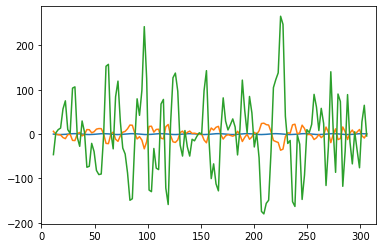

In [24]:
t=t_trim
print(t)
fig, ax = plt.subplots(1)
ax.set_xlim(0, 315)
ax.plot(t, hemi_alt_trim)
ax.plot(t, masked_ts_flat[32, :])
ax.plot(t, demean_ts_flat[32, :])
#ax.plot(t, masked_ts_flat[3222, :])
#ax.plot(t, masked_ts_flat[11513, :])
#ax.plot(t, masked_ts_flat[546434, :])

#### Correlation and Coherence

In [65]:
full_stim = np.vstack((hemifield_alternation_sinusoid, masked_ts_flat[:1000,:]))

In [66]:
full_stim.shape

(1001, 139)

In [67]:
test_ts = ts.TimeSeries(full_stim, sampling_interval=TR)

[[ 1.00000000e+00  8.29684585e-02  7.55211906e-04 ...  1.18079183e-01
   1.58933652e-01  1.39420560e-02]
 [ 8.29684585e-02  1.00000000e+00  1.09064749e-01 ... -6.18085188e-02
   2.19062774e-02 -9.90514841e-02]
 [ 7.55211906e-04  1.09064749e-01  1.00000000e+00 ... -3.24374239e-02
   1.39587294e-01 -1.61827793e-02]
 ...
 [ 1.18079183e-01 -6.18085188e-02 -3.24374239e-02 ...  1.00000000e+00
   6.11915692e-01  2.73513879e-01]
 [ 1.58933652e-01  2.19062774e-02  1.39587294e-01 ...  6.11915692e-01
   1.00000000e+00  2.87160514e-01]
 [ 1.39420560e-02 -9.90514841e-02 -1.61827793e-02 ...  2.73513879e-01
   2.87160514e-01  1.00000000e+00]]


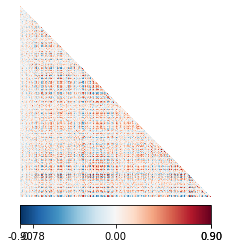

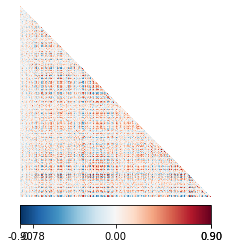

In [68]:
cr1 = nta.CorrelationAnalyzer(test_ts)
print(cr1.corrcoef)
ntv.drawmatrix_channels(cr1.corrcoef, color_anchor=0)

In [69]:
ch1 = nta.CoherenceAnalyzer(test_ts)
#physiologically relevant freq band
freq_idx = np.where((ch1.frequencies > 0.02) * (ch1.frequencies < 0.15))[0]
coh = np.mean(ch1.coherence[:,:,freq_idx], -1)
coh

array([[1.        , 0.37779493, 0.32042683, ..., 0.38391423, 0.38991971,
        0.41463472],
       [0.37779493, 1.        , 0.23704471, ..., 0.24363067, 0.33610133,
        0.34451442],
       [0.32042683, 0.23704471, 1.        , ..., 0.35312785, 0.41603584,
        0.38082879],
       ...,
       [0.38391423, 0.24363067, 0.35312785, ..., 1.        , 0.43222247,
        0.33214463],
       [0.38991971, 0.33610133, 0.41603584, ..., 0.43222247, 1.        ,
        0.24316907],
       [0.41463472, 0.34451442, 0.38082879, ..., 0.33214463, 0.24316907,
        1.        ]])

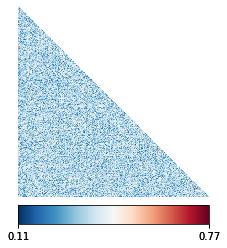

In [70]:
fig03 = ntv.drawmatrix_channels(coh)

In [71]:
ch1.phase[0,1]

array([ 0.        , -3.04458014,  0.55163698, -1.62073307,  1.20172279,
       -0.09583652, -0.70269503, -1.65437866,  0.96692921, -2.4791069 ,
        0.86816817,  0.1629574 , -2.09225998,  2.02597435, -1.14352947,
        0.75900993,  3.0932896 ,  1.43852122, -2.42888312, -1.19037202,
        1.6443321 , -1.84944079,  1.36442218, -2.9199945 , -0.14467537,
       -1.80231647,  2.41564131,  0.63751872, -1.82150506,  0.93343392,
       -0.46201294, -3.00524765,  0.        ])

#### SeedCoherenceAnalyzer

In [25]:
hemi_ts.sampling_interval

2.25 s

In [26]:
bold_flat = ts.TimeSeries(masked_ts_flat[:, :], sampling_interval=TR)
#bold_flat = ts.TimeSeries(demean_ts_flat[:, :], sampling_interval=TR)

In [27]:
n_seeds = 1

In [28]:
A = nta.SeedCoherenceAnalyzer(hemi_ts_trim, bold_flat)
B = nta.SeedCorrelationAnalyzer(hemi_ts_trim, bold_flat)
freq_idx = np.where((A.frequencies > f_lb) * (A.frequencies < f_ub))[0]
print(A.frequencies, A.frequencies[freq_idx], sep="\n")
cor = []
coh = []

for this_seed in range(n_seeds):
    #print(this_seed, A.coherence[this_seed], A.coherence[this_seed][freq_idx])
    # Extract the coherence and average across these frequency bands:
    print(A.coherence.shape, A.coherence[:, freq_idx], sep="\n")
    coh.append(np.mean(A.coherence[:, freq_idx], -1))  # Averaging on the last dimension
    cor.append(B.corrcoef[this_seed])  # No need to do any additional computation
        
print(coh, cor, sep="\n")

[0.         0.00694444 0.01388889 0.02083333 0.02777778 0.03472222
 0.04166667 0.04861111 0.05555556 0.0625     0.06944444 0.07638889
 0.08333333 0.09027778 0.09722222 0.10416667 0.11111111 0.11805556
 0.125      0.13194444 0.13888889 0.14583333 0.15277778 0.15972222
 0.16666667 0.17361111 0.18055556 0.1875     0.19444444 0.20138889
 0.20833333 0.21527778 0.22222222]
[0.02083333 0.02777778 0.03472222 0.04166667 0.04861111 0.05555556
 0.0625     0.06944444 0.07638889 0.08333333 0.09027778 0.09722222
 0.10416667 0.11111111 0.11805556 0.125      0.13194444 0.13888889
 0.14583333]
(117635, 33)
[[2.05045122e-03 3.35679286e-04 4.93420005e-02 ... 2.87638960e-01
  5.91812273e-01 8.64693037e-01]
 [5.09762140e-02 4.03768245e-02 1.14993257e-01 ... 3.85209730e-01
  2.00717915e-01 5.52117943e-01]
 [7.07227336e-01 4.51536802e-01 5.00803357e-01 ... 3.96372113e-01
  9.15447495e-03 1.58517820e-01]
 ...
 [6.56566285e-01 4.78757298e-01 1.73747205e-01 ... 1.66109877e-01
  3.97128860e-02 5.20631410e-01]
 [

In [29]:
len(coh[0])

117635

In [30]:
np.count_nonzero(coh[0])

117635

#### Write coherence values to Nifti file

In [31]:
coherence_img = masker.inverse_transform(coh[0])

In [32]:
coherence_img.shape

(128, 128, 21)

In [33]:
print(f"run-{run:02d}")

run-02


In [34]:
coh_fn = f"/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nitime/sub-{sub}_ses-{ses}_task-hemi_run-{run:02d}_desc-coherence-detrendmean_map.nii"
#coh_fn = f"/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nitime/sub-{sub}_ses-{ses}_task-hemi_run-{run:02d}_desc-coherence-demean_map.nii"
print(coh_fn)

/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nitime/sub-AV_ses-20111117_task-hemi_run-02_desc-coherence-detrendmean_map.nii


In [35]:
coherence_img.to_filename(coh_fn)

In [36]:
!ls "{coh_fn}"

/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nitime/sub-AV_ses-20111117_task-hemi_run-02_desc-coherence-detrendmean_map.nii


In [148]:
cmd = f"fsleyes /Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/anat/sub-AV_ses-20111117_run-01_T1w.nii.gz \
{bold_file} \
{coh_fn}"

In [80]:
print(cmd)

fsleyes /Users/smerdis/data/LGN/BIDS/AV_20111117/sub-AV/ses-20111117/anat/sub-AV_ses-20111117_run-01_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_desc-preproc_bold.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/nitime/sub-AV_ses-20111117_task-hemi_run-02_desc-coherence_map.nii


In [39]:
print(f"{utils.view_results(datasink_dir, [3], anat_file, bold_file)} {coh_fn}") # R-L

NameError: name 'datasink_dir' is not defined

### include an mrvista roi

In [56]:
mrv_roi_file = f"/Users/smerdis/data/LGN/BIDS/AV_20111117/derivatives/mrvista/sub-AV_ses-20111117_desc-lgnROI1prop20var000P_roi.nii.gz"
print(f"{utils.view_results(datasink_dir, [3], anat_file, bold_file)} {coh_fn} {mrv_roi_file}") # R-L

fsleyes /Users/smerdis/data/LGN/BIDS/AV_20111117/derivatives/fmriprep-1.4.1/fmriprep/sub-AV/anat/sub-AV_desc-preproc_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117/derivatives/fmriprep-1.4.1/fmriprep/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_space-T1w_desc-preproc_bold.nii.gz  /Users/smerdis/data/LGN/BIDS/AV_20111117/derivatives/nipype_AV_20111117_hemi_motionconfounds/hemi/modelfit/datasink/results_dir/_modelestimate0/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117/derivatives/nipype_AV_20111117_hemi_motionconfounds/hemi/modelfit/datasink/results_dir/_modelestimate1/results/cope3.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117/derivatives/nipype_AV_20111117_hemi_motionconfounds/hemi/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/AV_20111117/derivatives/nipype_AV_20111117_hemi_motionconfounds/sub-AV_ses-20111117_task-hemi_desc-coherence_map.nii /Users/smerdis/data/LGN/BIDS/AV_20111117/derivatives/mrvista/sub-AV

#### Some visualizations

(array([  143.,  2428., 11545., 24158., 28190., 18974.,  7683.,  1937.,
          308.,    33.]),
 array([0.0896128 , 0.14752925, 0.2054457 , 0.26336215, 0.32127861,
        0.37919506, 0.43711151, 0.49502796, 0.55294441, 0.61086086,
        0.66877731]),
 <a list of 10 Patch objects>)

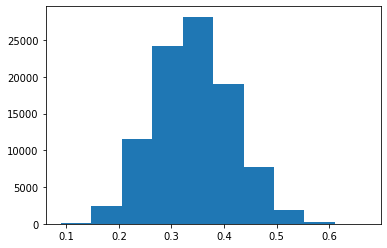

In [95]:
plt.hist(coh[0])

{'whiskers': [<matplotlib.lines.Line2D at 0x10ad908d0>,
 'caps': [<matplotlib.lines.Line2D at 0x10ad90fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x10ad90780>],
 'medians': [<matplotlib.lines.Line2D at 0x1c22ca86a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c22ca89e8>],
 'means': []}

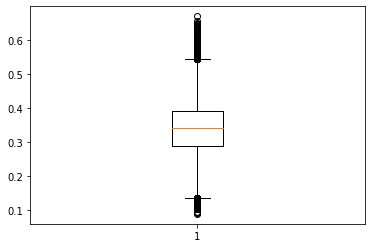

In [96]:
plt.boxplot(coh[0])

In [73]:
np.count_nonzero(coh[0]==0)

0

### Continue from here...

In [74]:
lgn_coh_low = 0.17
lgn_coh_high = 0.19
lgn_voxel_mask_coh = np.logical_and((coh[0] > lgn_coh_low), (coh[0] < lgn_coh_high))

In [75]:
np.count_nonzero(lgn_voxel_mask_coh)

873

## Assigning voxels within an ROI to M/P

In [ ]:
copefile = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_mp/hemifield/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz'
ROIfile = mROI

In [ ]:
def assign_mp_command(cope, roimask, pct_thresh, roi_below, roi_above, out_dir=None):
    if out_dir is None:
        out_dir = os.path.dirname(roimask)
    print(f"python assign_mp.py {cope} {roimask} {pct_thresh} {roi_below} {roi_above} {out_dir}")

def assign_voxels(infile, rois, split_pct):
    """Assign voxels to an ROI based on the percentile of intensity they fall in.
    
    rois should be a list of length 2, split_pcts should be a list of length 1
    
    e.g. assign_voxels_percentile(infile, ['M', 'P'], 80)"""
    from nipype.interfaces.fsl import ImageMaths
    stats = ImageMaths()
    stats.inputs.in_file = infile
    stats.inputs.op_string = f"-thr {split_pct} -bin {roi_above}"
    print(stats.cmdline)

In [ ]:
assign_mp_command(copefile, ROIfile, 80, 'M', 'P')

In [ ]:
masked_cope = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_hemi/hemifield/modelfit/datasink/cope_masked.nii.gz'

In [ ]:
assign_voxels_percentile(masked_cope, ['M', 'P'], 80)